In [ ]:
import torch.multiprocessing as mp
if __name__ == '__main__': 
    mp.set_start_method('spawn', force=True)  

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple
import re
from tqdm import tqdm

# Reuse the GoEmotionDataset class
class GoEmotionDataset:
    """
    A class to load, preprocess, and analyze the GoEmotions dataset.
    """
    
    EMOTIONS = [
        'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 
        'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 
        'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
        'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 
        'relief', 'remorse', 'sadness', 'surprise', 'neutral'
    ]
    
    POSITIVE_EMOTIONS = {
        "admiration", "amusement", "approval", "caring", "desire", "excitement",
        "gratitude", "joy", "love", "optimism", "pride", "relief"
    }
    
    AMBIGUOUS_EMOTIONS = {
        "confusion", "curiosity", "surprise", "realization", "neutral"
    }
    
    NEGATIVE_EMOTIONS = {
        "anger", "annoyance", "disappointment", "disapproval", "disgust",
        "embarrassment", "fear", "grief", "nervousness", "remorse", "sadness"
    }
    
    def __init__(self, train_path: str, test_path: str, val_path: str):
        """
        Initialize the dataset by loading and processing the data.
        
        Args:
            train_path: Path to training data CSV
            test_path: Path to test data CSV
            val_path: Path to validation data CSV
        """
        self.df = self._load_data(train_path, test_path, val_path)
        self._preprocess_data()
        
    def _load_data(self, train_path: str, test_path: str, val_path: str) -> pd.DataFrame:
        """Load and combine the dataset components."""
        train_df = pd.read_csv(train_path)
        test_df = pd.read_csv(test_path)
        val_df = pd.read_csv(val_path)
        
        main_df = pd.concat([train_df, test_df, val_df], axis=0)
        main_df = main_df.reset_index(drop=True)
        main_df.drop_duplicates(inplace=True)
        
        return main_df
    
    @staticmethod
    def _preprocess_text(text: str) -> str:
        """Clean and normalize text data."""
        if not isinstance(text, str):
            return ""
        # Preprocessing logic from the original class
        return text.lower()
    
    @staticmethod
    def _string_to_list(label_str: str) -> List[int]:
        """Convert string representation of array to list of integers."""
        return [int(x) for x in label_str.strip('[]').replace(',', '').split()]
    
    def _preprocess_data(self):
        """Apply all preprocessing steps to the dataset."""
        # Clean text
        self.df['clean_text'] = self.df['text'].apply(self._preprocess_text)
        
        # Ensure labels column contains lists
        if 'labels' in self.df.columns and isinstance(self.df['labels'].iloc[0], str):
            self.df['labels'] = self.df['labels'].apply(self._string_to_list)
        
        # Create one-hot encodings for emotions
        for i, emotion in enumerate(self.EMOTIONS):
            self.df[emotion] = self.df['labels'].apply(lambda x: 1 if i in x else 0)
        
        # Get the dominant emotion for each text
        self.df['dominant_emotion'] = self.df.apply(
            lambda row: self.EMOTIONS[np.argmax([row[emotion] for emotion in self.EMOTIONS])], 
            axis=1
        )
        
        self.df = self.df.drop(columns=['text', 'id'] if 'id' in self.df.columns else ['text'])
    
    def get_data(self) -> pd.DataFrame:
        """Return the processed DataFrame."""
        return self.df.copy()

    def get_emotion_labels(self) -> List[str]:
        """Return the list of emotion labels."""
        return self.EMOTIONS

In [ ]:
from MLP_probe_qwen_v3_helper import HiddenStatesDataset, EnhancedProbe

In [ ]:
import os
import json
import ijson
import re
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from tqdm import tqdm
from collections import defaultdict
import time
from concurrent.futures import ThreadPoolExecutor

class OptimizedProbeAnalyzer:
    """Optimized analyzer for training and evaluating probes on hidden states."""
    
    def __init__(self, hidden_states_dir: str, go_dataset, max_batches: int = None, device=None, chunk_size: int = 500):
        """
        Initialize the ProbeAnalyzer with optimized data loading.
        
        Args:
            hidden_states_dir: Directory containing hidden states JSON files
            go_dataset: GoEmotionDataset instance
            max_batches: Maximum number of batches to load (None for all)
            device: Device to run computations on (defaults to CUDA if available)
            chunk_size: Number of files to load at once
        """
        self.hidden_states_dir = hidden_states_dir
        self.go_dataset = go_dataset
        self.max_batches = max_batches
        self.device = device if device else ('cuda' if torch.cuda.is_available() else 'cpu')
        self.label_encoder = LabelEncoder()
        self.chunk_size = chunk_size
        
        # Find all hidden states files
        self.hidden_states_files = sorted([
            f for f in os.listdir(hidden_states_dir) 
            if f.startswith('QwenQwen2-7B_goEmo_') and f.endswith('.json')
        ])
        
        # Extract indices from filenames for ordering
        indices = [int(re.search(r'goEmo_(\d+)\.json', f).group(1)) for f in self.hidden_states_files]
        self.hidden_states_files = [f for _, f in sorted(zip(indices, self.hidden_states_files))]
        
        # Limit the number of batches if specified
        if self.max_batches is not None:
            self.hidden_states_files = self.hidden_states_files[:self.max_batches]
            print(f"Analysis limited to {len(self.hidden_states_files)} batches")
        
        # Initialize metrics storage
        self.metrics = {}
        self.stats = {}
        
        # Identify layers and prepare dataset without loading all data
        self._identify_layers()
        self._prepare_dataset()
    
    def _identify_layers(self):
        """Identify available layers from first file without loading all data."""
        print("Identifying layer structure...")
        with open(os.path.join(self.hidden_states_dir, self.hidden_states_files[0]), 'r') as f:
            first_batch = json.load(f)
            first_example = first_batch[0]
            self.layers = [key for key in first_example.keys() if key.startswith('layer_')]
        
        print(f"Identified {len(self.layers)} layers")
        
        # Calculate total examples by reading batch sizes
        self.total_examples = 0
        self.batch_sizes = []
        
        for file_name in tqdm(self.hidden_states_files, desc="Counting examples"):
            with open(os.path.join(self.hidden_states_dir, file_name), 'r') as f:
                batch_data = json.load(f)
                batch_size = len(batch_data)
                self.total_examples += batch_size
                self.batch_sizes.append(batch_size)
        
        print(f"Total examples: {self.total_examples}")
    
    def _prepare_dataset(self):
        """Prepare dataset metadata and train/test splits."""
        df = self.go_dataset.get_data()
        
        # Calculate which indices are valid (within dataset bounds)
        self.valid_mask = [True] * min(self.total_examples, len(df))
        self.valid_mask += [False] * max(0, self.total_examples - len(df))
        
        # Get labels only for valid indices
        valid_indices = np.where(self.valid_mask)[0]
        self.labels = df.iloc[valid_indices]['dominant_emotion'].values
        self.encoded_labels = self.label_encoder.fit_transform(self.labels)
        
        # Split data into train and test sets (80/20) using sklearn's train_test_split
        indices = np.arange(len(valid_indices))
        self.train_indices, self.test_indices = train_test_split(
            indices, test_size=0.2, random_state=42
        )
        
        print(f"Prepared metadata for {len(valid_indices)} valid examples")
        print(f"Train set: {len(self.train_indices)}, Test set: {len(self.test_indices)}")

    def _load_batch_file(self, file_path):
        """Optimized batch file loading using ijson"""
        with open(file_path, 'r') as f:
            return list(ijson.items(f, 'item'))
    
    def analyze_all_layers(self, layers_to_analyze, batch_size=32, epochs=50, max_workers=4):
        """Enhanced version with debugging checks"""
        print(f"Training probes for layers: {layers_to_analyze}")
        
        # Convert to layer keys and validate
        layers_to_analyze = [f'layer_{i}' for i in layers_to_analyze]
        valid_layers = set(self.layers)
        
        # Debug: Verify layer existence
        print(f"\nAvailable layers: {sorted(valid_layers)}")
        print(f"Requested layers: {sorted(layers_to_analyze)}")
        missing = set(layers_to_analyze) - valid_layers
        if missing:
            raise ValueError(f"Missing layers: {missing}")

        # Process each layer sequentially
        for layer_key in tqdm(layers_to_analyze, desc="Analyzing layers"):
            print(f"\n{'='*40}\nProcessing layer: {layer_key}\n{'='*40}")
            
            # Track example index across batches
            global_idx = 0
            layer_hidden_states = []
            layer_labels = []
            
            # Process files in order
            for batch_idx, batch_file in enumerate(tqdm(self.hidden_states_files, desc=f"Loading {layer_key}")):
                with open(os.path.join(self.hidden_states_dir, batch_file), 'r') as f:
                    batch_data = json.load(f)
                    
                    # Debug: Check batch structure
                    if batch_idx == 0:
                        print(f"\nFirst example structure: {list(batch_data[0].keys())}")
                        print(f"Hidden state shape: {len(batch_data[0][layer_key])}")
                    
                    # Get correct labels for this batch
                    batch_start = global_idx
                    batch_end = global_idx + len(batch_data)
                    batch_labels = self.encoded_labels[batch_start:batch_end]
                    
                    # Critical check: batch size alignment
                    if len(batch_data) != len(batch_labels):
                        print(f"\n⚠️ Batch {batch_file} size mismatch: {len(batch_data)} examples vs {len(batch_labels)} labels")
                        print(f"Global index: {global_idx}-{global_idx + len(batch_data)}")
                        print("Truncating to minimum size")
                        min_size = min(len(batch_data), len(batch_labels))
                        batch_data = batch_data[:min_size]
                        batch_labels = batch_labels[:min_size]
                    
                    global_idx += len(batch_data)
                    
                    # Debug: Sample labels
                    if batch_idx == 0:
                        print(f"\nFirst batch labels (encoded): {batch_labels[:5]}")
                        print(f"Corresponding text labels: {self.label_encoder.inverse_transform(batch_labels[:5])}")
                    
                    # Extract layer states
                    for example in batch_data:
                        layer_hidden_states.append(example[layer_key])
                    layer_labels.extend(batch_labels)
            
            # Convert to numpy arrays
            hidden_states = np.array(layer_hidden_states)
            labels = np.array(layer_labels)
            
            # Debug: Data statistics
            print(f"\n📊 Hidden states stats:")
            print(f"Shape: {hidden_states.shape}")
            print(f"Mean: {hidden_states.mean():.4f} ± {hidden_states.std():.4f}")
            print(f"NaN values: {np.isnan(hidden_states).sum()}")
            print(f"Zero values: {(hidden_states == 0).sum()} ({100*(hidden_states == 0).mean():.1f}%)")
            
            # Normalize hidden states
            hidden_states = (hidden_states - hidden_states.mean(axis=0)) / (hidden_states.std(axis=0) + 1e-8)
            
            # Split into train/test
            X_train = hidden_states[self.train_indices]
            y_train = labels[self.train_indices]
            X_test = hidden_states[self.test_indices]
            y_test = labels[self.test_indices]
            
            # Debug: Class distribution
            print("\n📈 Class distribution:")
            train_counts = np.unique(y_train, return_counts=True)[1]
            test_counts = np.unique(y_test, return_counts=True)[1]
            print(f"Train: {len(y_train)} examples, {len(train_counts)} classes")
            print(f"Test: {len(y_test)} examples, {len(test_counts)} classes")
            print(f"Most common class (train): {100*train_counts.max()/len(y_train):.1f}%")
            
            # Initialize probe model
            input_dim = hidden_states.shape[1]
            output_dim = len(np.unique(labels))
            print(f"\n🛠️ Model architecture:")
            print(f"Input dim: {input_dim}, Output dim: {output_dim}")
            
            probe = EnhancedProbe(
                input_dim=input_dim,
                hidden_dims=[256, 128],
                output_dim=output_dim
            ).to(self.device)
            
            # Debug: Model parameter check
            total_params = sum(p.numel() for p in probe.parameters())
            print(f"Total parameters: {total_params:,}")
            
            # Training setup
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.AdamW(probe.parameters(), lr=1e-3)
            
            # Debug: Initial forward pass
            with torch.no_grad():
                sample_input = torch.tensor(X_train[:1]).float().to(self.device)
                sample_output = probe(sample_input)
                print(f"\n🔎 Initial output check:")
                print(f"Input shape: {sample_input.shape}")
                print(f"Output shape: {sample_output.shape}")
                print(f"Output values: {sample_output[0].cpu().numpy()}")
            
            # Convert to PyTorch datasets
            train_dataset = HiddenStatesDataset(X_train, y_train)
            test_dataset = HiddenStatesDataset(X_test, y_test)

            # Initialize DataLoaders with error handling  <--- MISSING CODE
            try:
                train_loader = DataLoader(
                    train_dataset, 
                    batch_size=batch_size, 
                    shuffle=True,
                    num_workers=min(4, os.cpu_count()),
                    persistent_workers=True
                )
                test_loader = DataLoader(
                    test_dataset, 
                    batch_size=batch_size,
                    num_workers= min(4, os.cpu_count()),
                    persistent_workers=True
                )
                print(f"\n✅ Successfully created DataLoaders")
                print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")
            except Exception as e:
                print(f"\n❌ Failed to create DataLoaders: {str(e)}")
                print(f"Shapes - X_train: {X_train.shape}, y_train: {y_train.shape}")
                print(f"Data types - X: {type(X_train[0][0])}, y: {type(y_train[0])}")
                raise
            
            # Training loop
            train_losses = []
            val_losses = []
            best_accuracy = 0.0
            
            print("\n🚀 Training progress:")
            for epoch in range(epochs):
                probe.train()
                epoch_loss = 0.0
                gradient_norms = []
                
                for inputs, targets in train_loader:
                    inputs = inputs.to(self.device)
                    targets = targets.to(self.device)
                    
                    optimizer.zero_grad()
                    outputs = probe(inputs)
                    loss = criterion(outputs, targets)
                    loss.backward()
                    
                    # Gradient monitoring
                    grad_norm = 0.0
                    for name, param in probe.named_parameters():
                        if param.grad is not None:
                            grad_norm += param.grad.norm().item()
                    gradient_norms.append(grad_norm)
                    
                    optimizer.step()
                    epoch_loss += loss.item()
                
                avg_grad = sum(gradient_norms)/len(gradient_norms)
                train_losses.append(epoch_loss / len(train_loader))
                
                # Validation phase
                probe.eval()
                val_loss = 0.0
                correct = 0
                total = 0
                
                with torch.no_grad():
                    for inputs, targets in test_loader:
                        inputs = inputs.to(self.device)
                        targets = targets.to(self.device)
                        
                        outputs = probe(inputs)
                        loss = criterion(outputs, targets)
                        val_loss += loss.item()
                        
                        _, predicted = torch.max(outputs.data, 1)
                        total += targets.size(0)
                        correct += (predicted == targets).sum().item()
                
                val_accuracy = correct / total
                val_losses.append(val_loss / len(test_loader))
                
                # Debug: Training dynamics
                print(f"Epoch {epoch+1}/{epochs}")
                print(f"Train loss: {train_losses[-1]:.4f} | Val loss: {val_losses[-1]:.4f}")
                print(f"Val accuracy: {val_accuracy:.4f} | Grad norm: {avg_grad:.4f}")
                
                # Update best model
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_model_state = probe.state_dict().copy()
            
            # Final evaluation
            print("\n🔍 Final evaluation:")
            print(f"Best validation accuracy: {best_accuracy:.4f}")

            # Load best model
            probe.load_state_dict(best_model_state)
            
            # Final evaluation
            train_preds = self._get_predictions(probe, X_train, batch_size)
            test_preds = self._get_predictions(probe, X_test, batch_size)
            
            # Calculate metrics
            train_accuracy = accuracy_score(y_train, train_preds)
            test_accuracy = accuracy_score(y_test, test_preds)
            test_macro_f1 = f1_score(y_test, test_preds, average='macro')
            test_weighted_f1 = f1_score(y_test, test_preds, average='weighted')
                        
            # Store metrics
            self.metrics[layer_key] = {
                'train': {
                    'accuracy': train_accuracy,
                    'confusion_matrix': confusion_matrix(y_train, train_preds),
                    'hidden_states': X_train.tolist(),
                    'labels': y_train.tolist()
                },
                'test': {
                    'accuracy': test_accuracy,
                    'macro_f1': test_macro_f1,
                    'weighted_f1': test_weighted_f1,
                    'confusion_matrix': confusion_matrix(y_test, test_preds),
                    'hidden_states': X_test.tolist(),
                    'labels': y_test.tolist()
                },
                'loss_curves': {
                    'train': train_losses,
                    'val': val_losses
                }
            }
            
            # Calculate statistics
            self.stats[layer_key] = {
                'test': self._analyze_hidden_states(X_test, y_test),
                'train': self._analyze_hidden_states(X_train, y_train)
            }

        # Package final results
        self.results = {
            'metrics': self.metrics,
            'stats': self.stats,
            'label_encoder': self.label_encoder,
            'emotion_labels': self.go_dataset.get_emotion_labels(),
            'layer_order': sorted(self.metrics.keys(), key=lambda x: int(x.split('_')[1]))
        }
        
        return self.results

    def _get_predictions(self, model, hidden_states, batch_size):
        """Get model predictions from numpy array"""
        dataset = HiddenStatesDataset(hidden_states, np.zeros(len(hidden_states)))
        loader = DataLoader(dataset, batch_size=batch_size)
        
        model.eval()
        preds = []
        with torch.no_grad():
            for inputs, _ in loader:
                inputs = inputs.to(self.device)
                outputs = model(inputs)
                _, batch_preds = torch.max(outputs, 1)
                preds.extend(batch_preds.cpu().numpy())
        return np.array(preds)

    def _train_probe_for_layer(self, layer_key, train_hidden_states, train_labels, 
                             test_hidden_states, test_labels, test_raw_labels, 
                             batch_size, epochs):
        """Train probe and return metrics for both train and test sets"""
        # [Existing training code, but modified to return both train and test metrics]
        
        # Calculate train metrics
        train_preds = self._get_predictions(model, train_hidden_states, batch_size)
        train_accuracy = accuracy_score(train_labels, train_preds)
        
        return {
            'train': {
                'accuracy': train_accuracy,
                'confusion_matrix': confusion_matrix(train_labels, train_preds),
                'hidden_states': train_hidden_states,
                'labels': [self.label_encoder.inverse_transform([l])[0] for l in train_labels]
            },
            'test': {
                'accuracy': test_accuracy,
                'confusion_matrix': test_cm,
                'hidden_states': test_hidden_states,
                'labels': test_raw_labels,
                'pred_labels': test_pred_emotions
            },
            'loss_curves': {
                'train': train_losses,
                'val': val_losses
            }
        }

    def _analyze_hidden_states(self, hidden_states, labels):
        """Analyze hidden states statistics for a specific split."""
        hidden_states = np.array(hidden_states)
        labels = np.array(labels)
        
        # Calculate centroids
        unique_emotions = np.unique(labels)
        centroids = {}
        for emotion in unique_emotions:
            emotion_states = hidden_states[labels == emotion]
            if len(emotion_states) > 0:
                centroids[emotion] = emotion_states.mean(axis=0)
        
        # Calculate centroid similarities
        centroid_similarities = {}
        for i, e1 in enumerate(unique_emotions):
            for e2 in unique_emotions[i+1:]:
                if e1 in centroids and e2 in centroids:
                    c1, c2 = centroids[e1], centroids[e2]
                    similarity = np.dot(c1, c2)/(np.linalg.norm(c1)*np.linalg.norm(c2))
                    centroid_similarities[f"{e1}_vs_{e2}"] = similarity
        
        # Silhouette score
        try:
            silhouette = silhouette_score(hidden_states, labels) if len(unique_emotions) > 1 else -1
        except:
            silhouette = -1
        
        return {
            'centroids': centroids,
            'centroid_similarities': centroid_similarities,
            'silhouette_score': silhouette,
            'viz_labels': labels
        }
    def save_results(self, output_path: str):
        """Save all results to a file."""
        results = {
            'metrics': self.metrics,
            'stats': self.stats,
            'label_encoder': self.label_encoder,
            'emotion_labels': self.go_dataset.get_emotion_labels(),
            'layer_order': sorted(self.metrics.keys(), key=lambda x: int(x.split('_')[1]))
        }
        torch.save(results, output_path)

    @classmethod
    def load_results(cls, input_path: str):
        """Load saved results from file."""
        return torch.load(input_path)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

class ProbeVisualizer:
    """Visualizer with separate train/test plots and larger fonts."""
    
    def __init__(self, analysis_results):
        self.results = analysis_results
        self._setup_plot_styles()
    
    def _setup_plot_styles(self):
        """Configure consistent plotting styles"""
        plt.rcParams.update({
            'font.size': 14,
            'axes.titlesize': 18,
            'axes.labelsize': 16,
            'xtick.labelsize': 13,
            'ytick.labelsize': 13,
            'legend.fontsize': 12,
            'figure.titlesize': 20
        })
        sns.set_style("whitegrid")
    
    def visualize_all(self, output_dir='results', dpi=300):
        """Generate all visualizations with train/test separation"""
        os.makedirs(output_dir, exist_ok=True)
        
        self.plot_performance_metrics(output_dir, dpi)  # Renamed from plot_combined_metrics
        self.plot_accuracy_comparison(output_dir, dpi)
        self.plot_silhouette_scores(output_dir, dpi)
        
        for layer in self.results['layer_order']:
            self.plot_confusion_matrices(layer, output_dir, dpi)
            self.plot_tsne_projections(layer, output_dir, dpi)
            self.plot_loss_curves(layer, output_dir, dpi)
        
        self.save_summary_table(output_dir)
        print(f"All visualizations saved to {output_dir}")

    def plot_performance_metrics(self, output_dir, dpi=300):
        """Plot layer-wise performance metrics (originally called plot_combined_metrics)"""
        metrics = {
            'Accuracy': [self.results['metrics'][layer]['test']['accuracy'] for layer in self.results['layer_order']],
            'Macro F1': [self.results['metrics'][layer]['test']['macro_f1'] for layer in self.results['layer_order']],
            'Weighted F1': [self.results['metrics'][layer]['test']['weighted_f1'] for layer in self.results['layer_order']]
        }
        
        layer_indices = [int(layer.split('_')[1]) for layer in self.results['layer_order']]
        
        plt.figure(figsize=(14, 8), dpi=dpi)
        for metric_name, values in metrics.items():
            plt.plot(layer_indices, values, marker='o', markersize=8, linewidth=2, label=metric_name)
        
        plt.xlabel('Layer Index', fontweight='bold')
        plt.ylabel('Score', fontweight='bold')
        plt.title('Layer-wise Performance Metrics (Test Set)', fontweight='bold', pad=20)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'performance_metrics.png'), bbox_inches='tight', dpi=dpi)
        plt.close()

    def plot_accuracy_comparison(self, output_dir, dpi=300):
        """Plot train vs test accuracy across layers"""
        layers = self.results['layer_order']
        train_acc = [self.results['metrics'][l]['train']['accuracy'] for l in layers]
        test_acc = [self.results['metrics'][l]['test']['accuracy'] for l in layers]
        layer_nums = [int(l.split('_')[1]) for l in layers]
        
        plt.figure(figsize=(12, 7), dpi=dpi)
        plt.plot(layer_nums, train_acc, 'o-', label='Train Accuracy', linewidth=2)
        plt.plot(layer_nums, test_acc, 'o-', label='Test Accuracy', linewidth=2)
        
        plt.xlabel('Layer Index', fontweight='bold')
        plt.ylabel('Accuracy', fontweight='bold')
        plt.title('Train vs Test Accuracy by Layer', fontweight='bold', pad=20)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'accuracy_comparison.png'), bbox_inches='tight', dpi=dpi)
        plt.close()

    def plot_silhouette_scores(self, output_dir, dpi=300):
        """Plot silhouette scores across layers (test set)"""
        silhouette_scores = [self.results['stats'][layer]['test']['silhouette_score'] 
                        for layer in self.results['layer_order']]
        layer_indices = [int(layer.split('_')[1]) for layer in self.results['layer_order']]
        
        plt.figure(figsize=(12, 7), dpi=dpi)
        plt.plot(layer_indices, silhouette_scores, marker='o', markersize=8, 
                linewidth=2, color='darkorange')
        
        plt.xlabel('Layer Index', fontweight='bold')
        plt.ylabel('Silhouette Score', fontweight='bold')
        plt.title('Layer-wise Cluster Separation (Test Set)', fontweight='bold', pad=20)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'silhouette_scores.png'), 
                bbox_inches='tight', dpi=dpi)
        plt.close()

    def plot_confusion_matrices(self, layer, output_dir, dpi=300):
        """Plot both train and test confusion matrices for a specific layer"""
        for split in ['train', 'test']:
            cm = self.results['metrics'][layer][split]['confusion_matrix']
            labels = self.results['metrics'][layer][split]['labels']
            encoded_labels = self.results['metrics'][layer][split]['labels']
            label_names = self.results['label_encoder'].inverse_transform(encoded_labels)
            
            # Normalize and get top emotions
            with np.errstate(invalid='ignore'):
                cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
                cm_percent = np.nan_to_num(cm_percent, nan=0.0)
            
            emotion_counts = pd.Series(label_names).value_counts().values
            top_idx = np.argsort(emotion_counts)[-10:]  # Top 10 emotions
            top_emotions = [self.results['emotion_labels'][i] for i in top_idx]
            cm_top = cm_percent[top_idx][:, top_idx]
            
            plt.figure(figsize=(14, 12), dpi=dpi)
            sns.heatmap(
                cm_top, 
                annot=True, 
                fmt='.1f', 
                cmap='Blues',
                xticklabels=top_emotions,
                yticklabels=top_emotions,
                annot_kws={'size': 11}
            )
            plt.title(f'Confusion Matrix ({split.capitalize()} Set) - {layer}', fontweight='bold', pad=20)
            plt.xlabel('Predicted Emotion', fontweight='bold')
            plt.ylabel('True Emotion', fontweight='bold')
            plt.tight_layout()
            plt.savefig(
                os.path.join(output_dir, f'confusion_{split}_{layer}.png'), 
                bbox_inches='tight', 
                dpi=dpi
            )
            plt.close()

    def plot_tsne_projections(self, layer, output_dir, dpi=300, perplexity=30):
        """Generate t-SNE plots for both train and test sets of a specific layer"""
        for split in ['train', 'test']:
            hidden_states = np.array(self.results['metrics'][layer][split]['hidden_states'])
            labels = self.results['metrics'][layer][split]['labels']
            
            # Subsample if needed
            if len(hidden_states) > 1000:
                idx = np.random.choice(len(hidden_states), 1000, replace=False)
                hidden_states = hidden_states[idx]
                labels = [labels[i] for i in idx]
            
            # Compute t-SNE
            try:
                tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
                tsne_result = tsne.fit_transform(hidden_states)
            except:
                print(f"Skipping t-SNE for {layer} {split} set due to error")
                continue
            
            # Plot with top emotions
            unique_emotions, counts = np.unique(labels, return_counts=True)
            top_emotions = unique_emotions[np.argsort(counts)[-5:]]  # Top 5 emotions
            
            plt.figure(figsize=(12, 10), dpi=dpi)
            colors = plt.cm.tab10(np.linspace(0, 1, len(top_emotions)))
            
            for i, emotion in enumerate(top_emotions):
                mask = np.array(labels) == emotion
                plt.scatter(
                    tsne_result[mask, 0], 
                    tsne_result[mask, 1], 
                    label=emotion,
                    color=colors[i],
                    alpha=0.7,
                    s=50
                )
            plt.title(f't-SNE Projection ({split.capitalize()} Set) - {layer}', fontweight='bold', pad=20)
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig(
                os.path.join(output_dir, f'tsne_{split}_{layer}.png'), 
                bbox_inches='tight', 
                dpi=dpi
            )
            plt.close()

    def plot_loss_curves(self, layer, output_dir, dpi=300):
        """Plot training/validation loss curves for a specific layer"""
        train_losses = self.results['metrics'][layer]['loss_curves']['train']
        val_losses = self.results['metrics'][layer]['loss_curves']['val']
        
        plt.figure(figsize=(12, 7), dpi=dpi)
        plt.plot(train_losses, label='Training Loss', linewidth=2)
        plt.plot(val_losses, label='Validation Loss', linewidth=2)
        
        plt.xlabel('Epoch', fontweight='bold')
        plt.ylabel('Loss', fontweight='bold')
        plt.title(f'Training Progress - {layer}', fontweight='bold', pad=20)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(
            os.path.join(output_dir, f'loss_curves_{layer}.png'), 
            bbox_inches='tight', 
            dpi=dpi
        )
        plt.close()

    def save_summary_table(self, output_dir):
        """Save metrics summary as CSV and HTML"""
        summary_data = []
        for layer in self.results['layer_order']:
            summary_data.append({
                'Layer': int(layer.split('_')[1]),
                'Train Accuracy': self.results['metrics'][layer]['train']['accuracy'],
                'Test Accuracy': self.results['metrics'][layer]['test']['accuracy'],
                'Test Macro F1': self.results['metrics'][layer]['test']['macro_f1'],
                'Test Weighted F1': self.results['metrics'][layer]['test']['weighted_f1'],
                'Silhouette Score': self.results['stats'][layer]['test']['silhouette_score']
            })
        
        df = pd.DataFrame(summary_data)
        
        # Save CSV
        df.to_csv(os.path.join(output_dir, 'metrics_summary.csv'), index=False)
        
        # Save styled HTML
        styled_df = df.style\
            .background_gradient(cmap='Blues', subset=['Test Accuracy', 'Test Macro F1'])\
            .format('{:.3f}', subset=['Train Accuracy', 'Test Accuracy', 'Test Macro F1', 'Test Weighted F1'])\
            .set_caption('Probe Performance Summary')
        
        with open(os.path.join(output_dir, 'metrics_summary.html'), 'w') as f:
            f.write(styled_df.to_html())

In [ ]:
# 1. Load the GoEmotions dataset
go_dataset = GoEmotionDataset(
    train_path='Go_Emotion_Google/go_emotions_train.csv',
    test_path='Go_Emotion_Google/go_emotions_test.csv',
    val_path='Go_Emotion_Google/go_emotions_validation.csv'
)

In [ ]:
import time
from concurrent.futures import ThreadPoolExecutor

max_batches=57
if __name__ == '__main__':
    analyzer = OptimizedProbeAnalyzer(
        hidden_states_dir='QWEN_hidden_states',
        go_dataset=go_dataset,
        max_batches=max_batches,  # Limit to specified number of batches
        chunk_size=10  # Process 5 files at a time
    )

In [8]:
results = analyzer.analyze_all_layers([0, 4,  10, 12, 14, 16, 18, 20, 24, 26, 28]) 
analyzer.save_results("full_results.pt")

Epoch 30/50
Train loss: 1.4113 | Val loss: 4.3169
Val accuracy: 0.3005 | Grad norm: 5.2833
Epoch 31/50
Train loss: 1.4016 | Val loss: 4.2968
Val accuracy: 0.2568 | Grad norm: 5.2354
Epoch 32/50
Train loss: 1.3951 | Val loss: 4.2402
Val accuracy: 0.2842 | Grad norm: 5.2175
Epoch 33/50
Train loss: 1.4035 | Val loss: 4.3030
Val accuracy: 0.2951 | Grad norm: 5.3777
Epoch 34/50
Train loss: 1.3928 | Val loss: 4.3045
Val accuracy: 0.2842 | Grad norm: 5.2886
Epoch 35/50
Train loss: 1.3938 | Val loss: 4.3493
Val accuracy: 0.2896 | Grad norm: 5.1892
Epoch 36/50
Train loss: 1.4091 | Val loss: 4.2890
Val accuracy: 0.2623 | Grad norm: 5.4592
Epoch 37/50
Train loss: 1.4079 | Val loss: 4.3724
Val accuracy: 0.2787 | Grad norm: 5.2782
Epoch 38/50
Train loss: 1.4042 | Val loss: 4.3839
Val accuracy: 0.2842 | Grad norm: 5.1538
Epoch 39/50
Train loss: 1.3899 | Val loss: 4.3434
Val accuracy: 0.2459 | Grad norm: 5.2289
Epoch 40/50
Train loss: 1.3945 | Val loss: 4.4523
Val accuracy: 0.2732 | Grad norm: 5.1653

Analyzing layers:  27%|██▋       | 3/11 [04:20<12:07, 90.96s/it]


Processing layer: layer_12



First example structure: ['layer_0', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'layer_6', 'layer_7', 'layer_8', 'layer_9', 'layer_10', 'layer_11', 'layer_12', 'layer_13', 'layer_14', 'layer_15', 'layer_16', 'layer_17', 'layer_18', 'layer_19', 'layer_20', 'layer_21', 'layer_22', 'layer_23', 'layer_24', 'layer_25', 'layer_26', 'layer_27', 'layer_28']
Hidden state shape: 3584

First batch labels (encoded): [20 20  2 14  3]
Corresponding text labels: ['neutral' 'neutral' 'anger' 'fear' 'annoyance']


Loading layer_12: 100%|██████████| 57/57 [00:36<00:00,  1.57it/s]



📊 Hidden states stats:
Shape: (912, 3584)
Mean: -2.0897 ± 158.4785
NaN values: 0
Zero values: 0 (0.0%)

📈 Class distribution:
Train: 729 examples, 27 classes
Test: 183 examples, 25 classes
Most common class (train): 30.0%

🛠️ Model architecture:
Input dim: 3584, Output dim: 28
Total parameters: 954,268

🔎 Initial output check:
Input shape: torch.Size([1, 3584])
Output shape: torch.Size([1, 28])
Output values: [ 0.0566814  -0.14166698  0.07838421  0.12041816 -0.11162876  0.06840853
  0.100112    0.06516021 -0.03173156 -0.11169802 -0.08671614 -0.00319907
 -0.08130847  0.09277872  0.01140749 -0.15887564 -0.13101482 -0.00033284
 -0.08002894 -0.00798779  0.02745067  0.02305683 -0.14463174 -0.07677421
 -0.13920164  0.1248448   0.02942399 -0.01460556]

✅ Successfully created DataLoaders
Train batches: 23, Test batches: 6

🚀 Training progress:
Epoch 1/50
Train loss: 2.9940 | Val loss: 2.9281
Val accuracy: 0.2514 | Grad norm: 5.5642
Epoch 2/50
Train loss: 2.2470 | Val loss: 3.0252
Val accuracy

Analyzing layers:  36%|███▋      | 4/11 [05:58<10:55, 93.71s/it]


Processing layer: layer_14



First example structure: ['layer_0', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'layer_6', 'layer_7', 'layer_8', 'layer_9', 'layer_10', 'layer_11', 'layer_12', 'layer_13', 'layer_14', 'layer_15', 'layer_16', 'layer_17', 'layer_18', 'layer_19', 'layer_20', 'layer_21', 'layer_22', 'layer_23', 'layer_24', 'layer_25', 'layer_26', 'layer_27', 'layer_28']
Hidden state shape: 3584

First batch labels (encoded): [20 20  2 14  3]
Corresponding text labels: ['neutral' 'neutral' 'anger' 'fear' 'annoyance']


Loading layer_14: 100%|██████████| 57/57 [00:35<00:00,  1.60it/s]



📊 Hidden states stats:
Shape: (912, 3584)
Mean: -2.1602 ± 160.9224
NaN values: 0
Zero values: 0 (0.0%)

📈 Class distribution:
Train: 729 examples, 27 classes
Test: 183 examples, 25 classes
Most common class (train): 30.0%

🛠️ Model architecture:
Input dim: 3584, Output dim: 28
Total parameters: 954,268

🔎 Initial output check:
Input shape: torch.Size([1, 3584])
Output shape: torch.Size([1, 28])
Output values: [-0.017039    0.01269732 -0.00231685 -0.01165075 -0.04136952  0.13517195
 -0.0087662  -0.18384951  0.02849104  0.03560651 -0.05055892 -0.07322765
  0.01371176  0.13076499 -0.08122183 -0.17030598 -0.01441919 -0.07425025
  0.03088707 -0.00730649 -0.14531046 -0.02241231  0.09164823  0.00939081
  0.10837932  0.11004641 -0.02609226  0.01855808]

✅ Successfully created DataLoaders
Train batches: 23, Test batches: 6

🚀 Training progress:
Epoch 1/50
Train loss: 2.9896 | Val loss: 2.9303
Val accuracy: 0.3115 | Grad norm: 5.0805
Epoch 2/50
Train loss: 2.2430 | Val loss: 2.9963
Val accuracy

Analyzing layers:  45%|████▌     | 5/11 [07:35<09:30, 95.09s/it]


Processing layer: layer_16



First example structure: ['layer_0', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'layer_6', 'layer_7', 'layer_8', 'layer_9', 'layer_10', 'layer_11', 'layer_12', 'layer_13', 'layer_14', 'layer_15', 'layer_16', 'layer_17', 'layer_18', 'layer_19', 'layer_20', 'layer_21', 'layer_22', 'layer_23', 'layer_24', 'layer_25', 'layer_26', 'layer_27', 'layer_28']
Hidden state shape: 3584

First batch labels (encoded): [20 20  2 14  3]
Corresponding text labels: ['neutral' 'neutral' 'anger' 'fear' 'annoyance']


Loading layer_16: 100%|██████████| 57/57 [00:37<00:00,  1.53it/s]



📊 Hidden states stats:
Shape: (912, 3584)
Mean: -2.1715 ± 161.5538
NaN values: 0
Zero values: 0 (0.0%)

📈 Class distribution:
Train: 729 examples, 27 classes
Test: 183 examples, 25 classes
Most common class (train): 30.0%

🛠️ Model architecture:
Input dim: 3584, Output dim: 28
Total parameters: 954,268

🔎 Initial output check:
Input shape: torch.Size([1, 3584])
Output shape: torch.Size([1, 28])
Output values: [-0.01988605  0.01131436  0.01889369  0.1798298  -0.03237037 -0.05081386
  0.06233434 -0.02254087  0.04107973 -0.03832214 -0.08510822 -0.13932863
 -0.03525453 -0.02892421  0.03866501 -0.02219715 -0.00311535  0.01756801
 -0.01523703  0.06504431  0.0611703   0.00877718  0.09475921  0.04288996
  0.06943982 -0.02913993 -0.11021233  0.0077122 ]

✅ Successfully created DataLoaders
Train batches: 23, Test batches: 6

🚀 Training progress:
Epoch 1/50
Train loss: 3.0160 | Val loss: 2.9677
Val accuracy: 0.2459 | Grad norm: 5.4595
Epoch 2/50
Train loss: 2.2405 | Val loss: 2.8960
Val accuracy

Analyzing layers:  55%|█████▍    | 6/11 [09:20<08:13, 98.61s/it]


Processing layer: layer_18



First example structure: ['layer_0', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'layer_6', 'layer_7', 'layer_8', 'layer_9', 'layer_10', 'layer_11', 'layer_12', 'layer_13', 'layer_14', 'layer_15', 'layer_16', 'layer_17', 'layer_18', 'layer_19', 'layer_20', 'layer_21', 'layer_22', 'layer_23', 'layer_24', 'layer_25', 'layer_26', 'layer_27', 'layer_28']
Hidden state shape: 3584

First batch labels (encoded): [20 20  2 14  3]
Corresponding text labels: ['neutral' 'neutral' 'anger' 'fear' 'annoyance']


Loading layer_18: 100%|██████████| 57/57 [00:36<00:00,  1.56it/s]



📊 Hidden states stats:
Shape: (912, 3584)
Mean: -2.1681 ± 161.6286
NaN values: 0
Zero values: 0 (0.0%)

📈 Class distribution:
Train: 729 examples, 27 classes
Test: 183 examples, 25 classes
Most common class (train): 30.0%

🛠️ Model architecture:
Input dim: 3584, Output dim: 28
Total parameters: 954,268

🔎 Initial output check:
Input shape: torch.Size([1, 3584])
Output shape: torch.Size([1, 28])
Output values: [-0.08679248 -0.04718031 -0.0877412  -0.03191418 -0.09975345 -0.14835986
 -0.03718879  0.07696023  0.05158982  0.13380168  0.01033483 -0.02129475
 -0.00498493 -0.03248177 -0.13548048 -0.01028241  0.06853399  0.04525393
  0.05444678 -0.07475743  0.06308485 -0.03063504 -0.00379692  0.05096617
  0.20439309 -0.0651594   0.05981247 -0.07618836]

✅ Successfully created DataLoaders
Train batches: 23, Test batches: 6

🚀 Training progress:
Epoch 1/50
Train loss: 2.9688 | Val loss: 2.8635
Val accuracy: 0.2623 | Grad norm: 5.3969
Epoch 2/50
Train loss: 2.2073 | Val loss: 2.9295
Val accuracy

Analyzing layers:  64%|██████▎   | 7/11 [10:58<06:32, 98.23s/it]


Processing layer: layer_20



First example structure: ['layer_0', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'layer_6', 'layer_7', 'layer_8', 'layer_9', 'layer_10', 'layer_11', 'layer_12', 'layer_13', 'layer_14', 'layer_15', 'layer_16', 'layer_17', 'layer_18', 'layer_19', 'layer_20', 'layer_21', 'layer_22', 'layer_23', 'layer_24', 'layer_25', 'layer_26', 'layer_27', 'layer_28']
Hidden state shape: 3584

First batch labels (encoded): [20 20  2 14  3]
Corresponding text labels: ['neutral' 'neutral' 'anger' 'fear' 'annoyance']


Loading layer_20: 100%|██████████| 57/57 [00:35<00:00,  1.59it/s]



📊 Hidden states stats:
Shape: (912, 3584)
Mean: -2.1492 ± 161.3840
NaN values: 0
Zero values: 0 (0.0%)

📈 Class distribution:
Train: 729 examples, 27 classes
Test: 183 examples, 25 classes
Most common class (train): 30.0%

🛠️ Model architecture:
Input dim: 3584, Output dim: 28
Total parameters: 954,268

🔎 Initial output check:
Input shape: torch.Size([1, 3584])
Output shape: torch.Size([1, 28])
Output values: [-0.01673224 -0.0567199  -0.16220072 -0.02479071  0.08580045 -0.18712509
  0.12740245 -0.0406538  -0.00349668  0.04243636  0.03810477 -0.10374416
  0.14442822 -0.09125258  0.06069939  0.01088894 -0.11039123  0.02030076
 -0.15151788  0.01461374  0.06430233 -0.06417212 -0.01870232  0.05081892
  0.07814319 -0.05560888 -0.01247051 -0.10116368]

✅ Successfully created DataLoaders
Train batches: 23, Test batches: 6

🚀 Training progress:
Epoch 1/50
Train loss: 2.9336 | Val loss: 2.8324
Val accuracy: 0.3005 | Grad norm: 5.2961
Epoch 2/50
Train loss: 2.1919 | Val loss: 3.0627
Val accuracy

Analyzing layers:  73%|███████▎  | 8/11 [12:35<04:53, 97.93s/it]


Processing layer: layer_24



First example structure: ['layer_0', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'layer_6', 'layer_7', 'layer_8', 'layer_9', 'layer_10', 'layer_11', 'layer_12', 'layer_13', 'layer_14', 'layer_15', 'layer_16', 'layer_17', 'layer_18', 'layer_19', 'layer_20', 'layer_21', 'layer_22', 'layer_23', 'layer_24', 'layer_25', 'layer_26', 'layer_27', 'layer_28']
Hidden state shape: 3584

First batch labels (encoded): [20 20  2 14  3]
Corresponding text labels: ['neutral' 'neutral' 'anger' 'fear' 'annoyance']


Loading layer_24: 100%|██████████| 57/57 [00:37<00:00,  1.50it/s]



📊 Hidden states stats:
Shape: (912, 3584)
Mean: -2.0608 ± 158.6976
NaN values: 0
Zero values: 0 (0.0%)

📈 Class distribution:
Train: 729 examples, 27 classes
Test: 183 examples, 25 classes
Most common class (train): 30.0%

🛠️ Model architecture:
Input dim: 3584, Output dim: 28
Total parameters: 954,268

🔎 Initial output check:
Input shape: torch.Size([1, 3584])
Output shape: torch.Size([1, 28])
Output values: [-0.15985826 -0.02220251  0.20244095  0.05341677 -0.09739347  0.0802312
 -0.03354957  0.10729519 -0.07065894 -0.02139542 -0.01314086  0.02366888
  0.0933581  -0.10155277  0.06997407 -0.1281826  -0.02804241  0.0547495
  0.1219525  -0.02141892  0.08110287  0.16399951  0.04140443  0.00798918
 -0.06817663 -0.0464478  -0.04257988 -0.1005659 ]

✅ Successfully created DataLoaders
Train batches: 23, Test batches: 6

🚀 Training progress:
Epoch 1/50
Train loss: 2.9534 | Val loss: 2.8956
Val accuracy: 0.2732 | Grad norm: 5.3762
Epoch 2/50
Train loss: 2.2078 | Val loss: 3.0581
Val accuracy: 

Analyzing layers:  82%|████████▏ | 9/11 [14:17<03:18, 99.02s/it]


Processing layer: layer_26



First example structure: ['layer_0', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'layer_6', 'layer_7', 'layer_8', 'layer_9', 'layer_10', 'layer_11', 'layer_12', 'layer_13', 'layer_14', 'layer_15', 'layer_16', 'layer_17', 'layer_18', 'layer_19', 'layer_20', 'layer_21', 'layer_22', 'layer_23', 'layer_24', 'layer_25', 'layer_26', 'layer_27', 'layer_28']
Hidden state shape: 3584

First batch labels (encoded): [20 20  2 14  3]
Corresponding text labels: ['neutral' 'neutral' 'anger' 'fear' 'annoyance']


Loading layer_26: 100%|██████████| 57/57 [00:39<00:00,  1.45it/s]



📊 Hidden states stats:
Shape: (912, 3584)
Mean: -1.8446 ± 153.2518
NaN values: 0
Zero values: 0 (0.0%)

📈 Class distribution:
Train: 729 examples, 27 classes
Test: 183 examples, 25 classes
Most common class (train): 30.0%

🛠️ Model architecture:
Input dim: 3584, Output dim: 28
Total parameters: 954,268

🔎 Initial output check:
Input shape: torch.Size([1, 3584])
Output shape: torch.Size([1, 28])
Output values: [ 0.07764183 -0.06209766 -0.01813156  0.09309688 -0.12595698  0.16166201
 -0.03012459 -0.07987171 -0.13267714 -0.12869851 -0.04809904  0.03287131
  0.07245585 -0.06999925  0.05380919  0.1239585  -0.1618824  -0.13580778
 -0.00605082  0.10959676  0.26772335  0.12702543 -0.0883136   0.02490366
 -0.06183422  0.12036686 -0.01837524  0.09651852]

✅ Successfully created DataLoaders
Train batches: 23, Test batches: 6

🚀 Training progress:
Epoch 1/50
Train loss: 2.9665 | Val loss: 2.8842
Val accuracy: 0.3333 | Grad norm: 5.3327
Epoch 2/50
Train loss: 2.2391 | Val loss: 2.9327
Val accuracy

Analyzing layers:  91%|█████████ | 10/11 [15:58<01:39, 99.74s/it]


Processing layer: layer_28



First example structure: ['layer_0', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'layer_6', 'layer_7', 'layer_8', 'layer_9', 'layer_10', 'layer_11', 'layer_12', 'layer_13', 'layer_14', 'layer_15', 'layer_16', 'layer_17', 'layer_18', 'layer_19', 'layer_20', 'layer_21', 'layer_22', 'layer_23', 'layer_24', 'layer_25', 'layer_26', 'layer_27', 'layer_28']
Hidden state shape: 3584

First batch labels (encoded): [20 20  2 14  3]
Corresponding text labels: ['neutral' 'neutral' 'anger' 'fear' 'annoyance']


Loading layer_28: 100%|██████████| 57/57 [00:35<00:00,  1.61it/s]



📊 Hidden states stats:
Shape: (912, 3584)
Mean: 0.1140 ± 3.4073
NaN values: 0
Zero values: 0 (0.0%)

📈 Class distribution:
Train: 729 examples, 27 classes
Test: 183 examples, 25 classes
Most common class (train): 30.0%

🛠️ Model architecture:
Input dim: 3584, Output dim: 28
Total parameters: 954,268

🔎 Initial output check:
Input shape: torch.Size([1, 3584])
Output shape: torch.Size([1, 28])
Output values: [-0.00704179 -0.02607414  0.08619861 -0.03410428  0.00284726 -0.11988525
 -0.00385721  0.12423632  0.00509917  0.08090704  0.02552824  0.17738086
 -0.09115104  0.07111061  0.1449005   0.08604081  0.08205535  0.01569141
  0.07346233  0.02853049 -0.03117895 -0.09427745  0.10772949 -0.02278318
 -0.14323342  0.02360968 -0.06724395  0.08768927]

✅ Successfully created DataLoaders
Train batches: 23, Test batches: 6

🚀 Training progress:
Epoch 1/50
Train loss: 2.9446 | Val loss: 2.9316
Val accuracy: 0.2896 | Grad norm: 5.2617
Epoch 2/50
Train loss: 2.2390 | Val loss: 3.0240
Val accuracy: 0

Analyzing layers: 100%|██████████| 11/11 [17:35<00:00, 95.98s/it]


In [9]:
# Visualize
loaded_results = OptimizedProbeAnalyzer.load_results("full_results.pt")
visualizer = ProbeVisualizer(loaded_results)
visualizer.visualize_all()

/Users/amirali/Desktop/Final-Year-Project/.venv/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


All visualizations saved to results


FileNotFoundError: [Errno 2] No such file or directory: 'confusion_mats/confusion_train_layer_10.png'

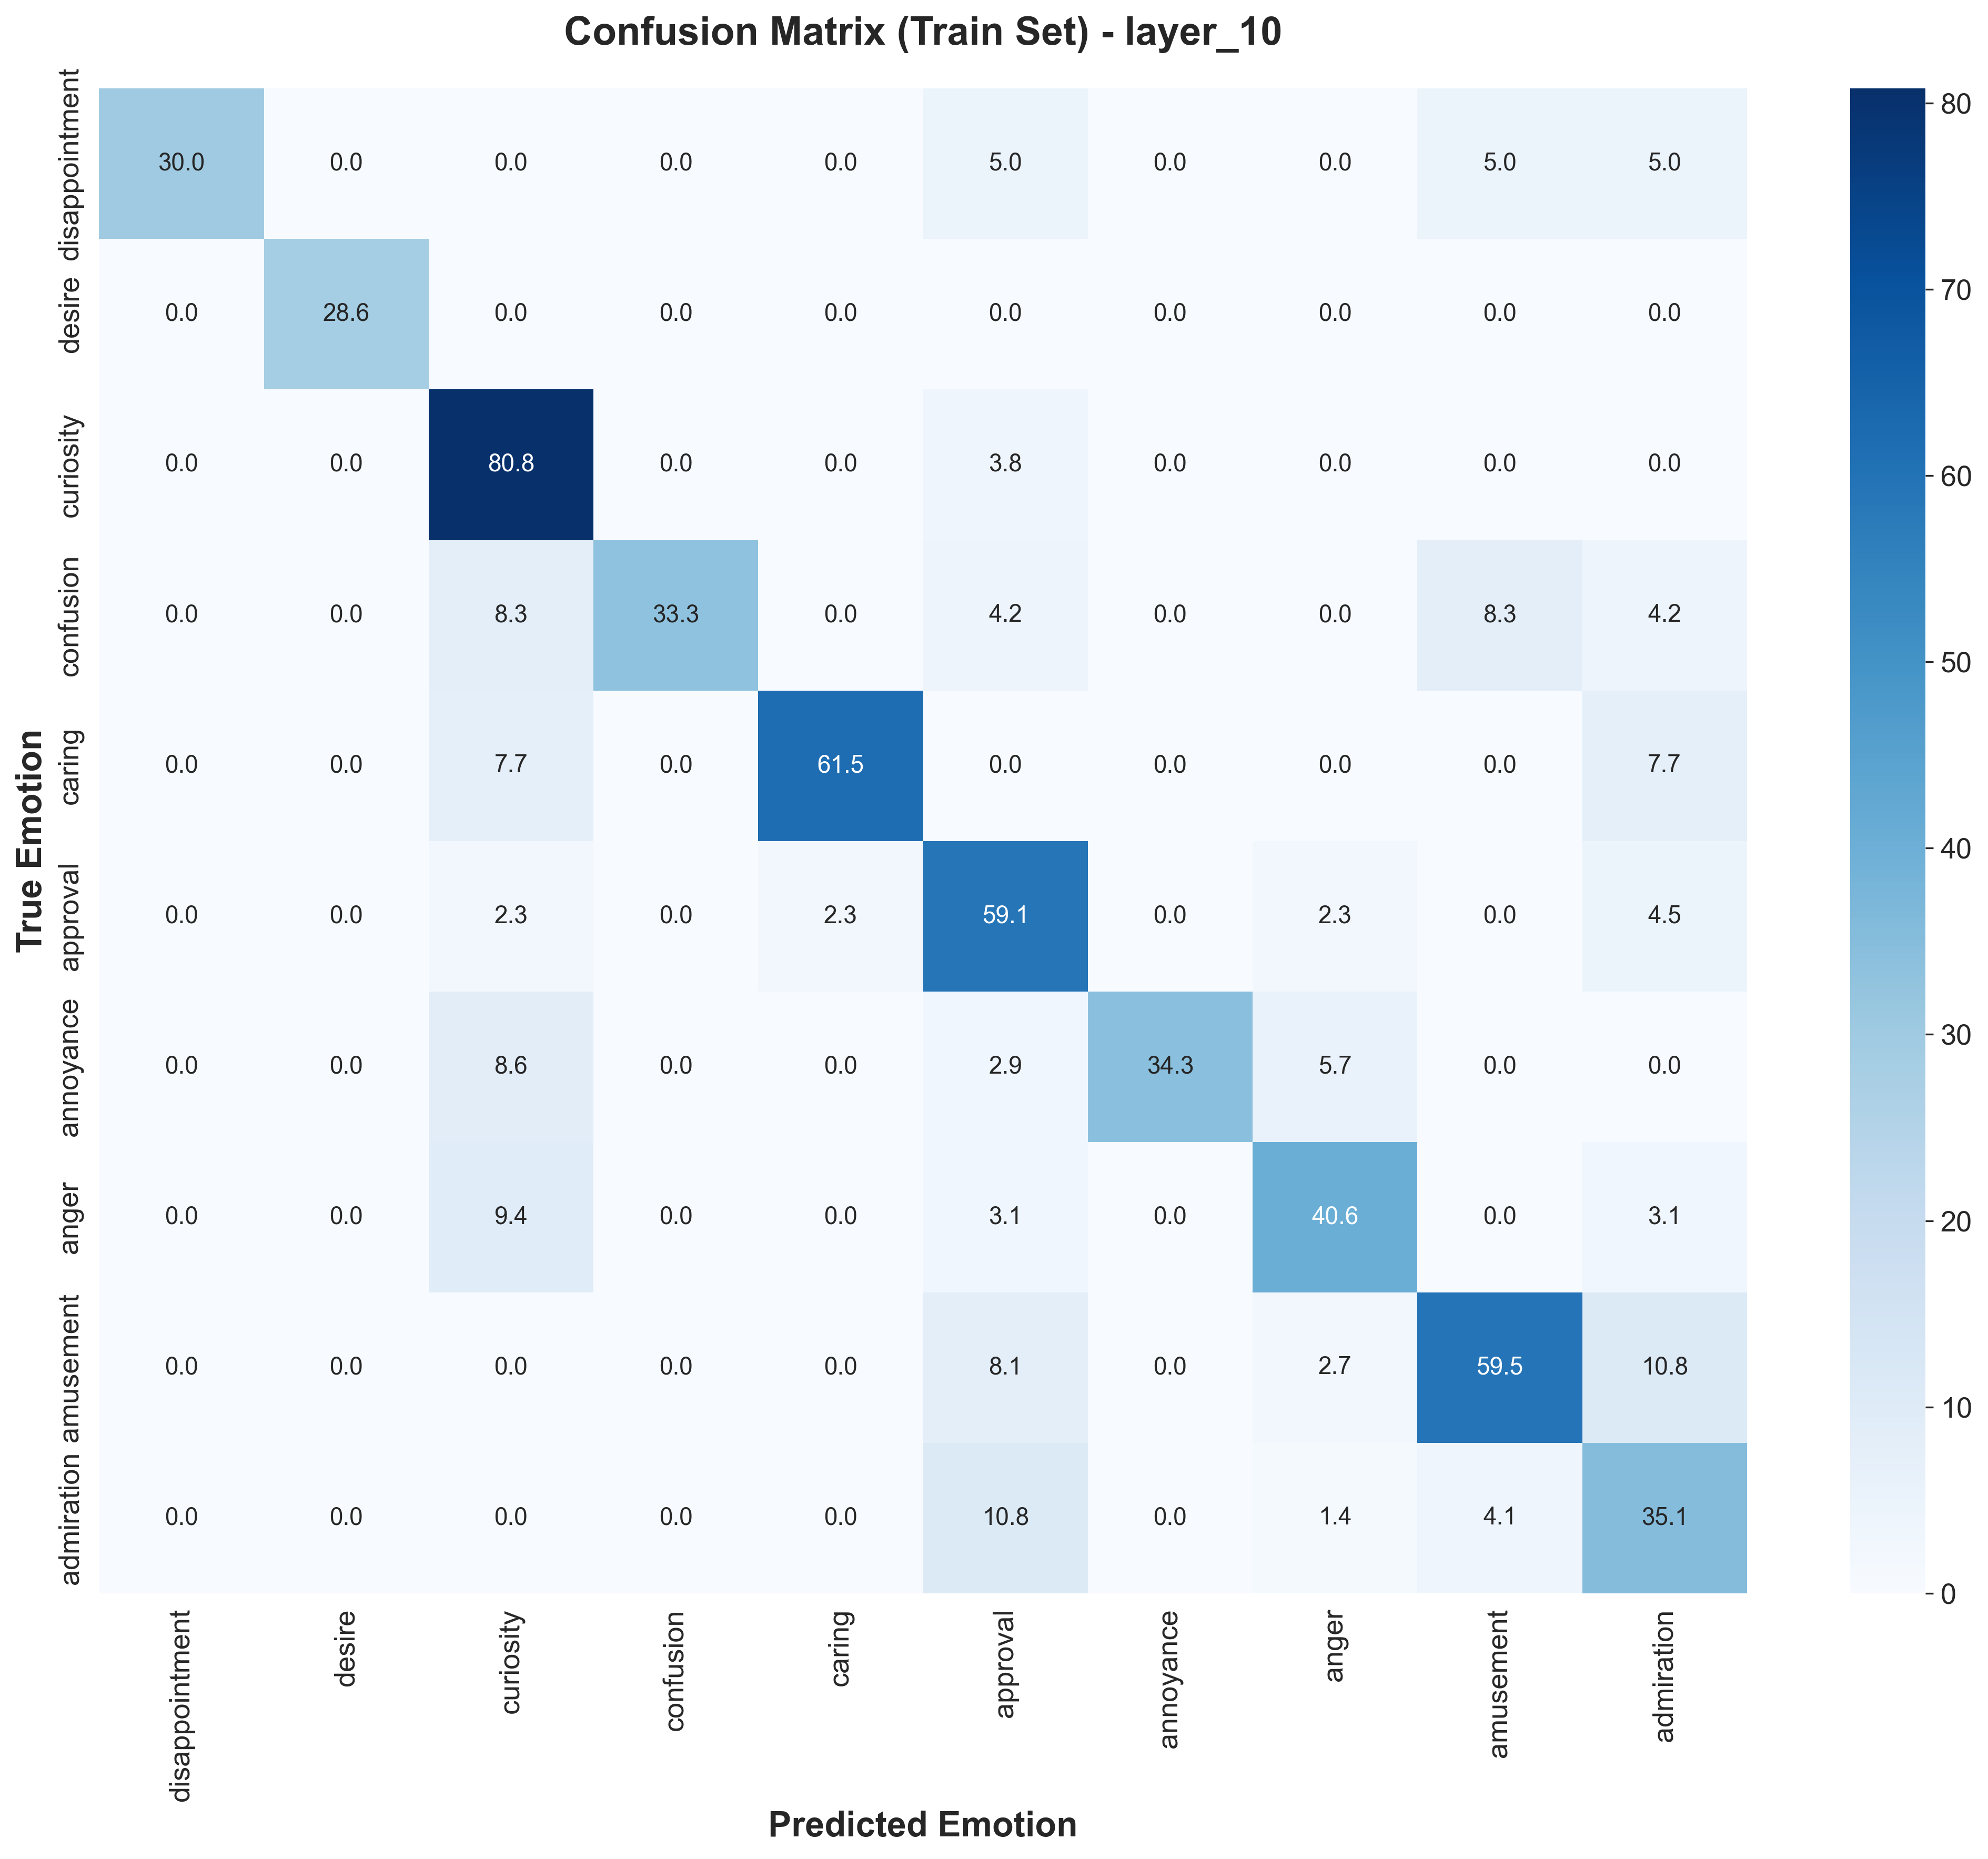

In [10]:
visualizer.plot_confusion_matrices('layer_10', output_dir='confusion_mats')
visualizer.plot_tsne_projections('layer_20', output_dir='tsne_plots')